# Advanced Lane Finding
In order to manipulate a car I need to measure how much my lane is curving. To do that I need to map out the lanes in my camera image.

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

def arrange_side_by_side(img1, img2, title1, title2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 30))
    ax1.imshow(img1)
    ax1.set_title(title1)
    ax2.imshow(img2, cmap='gray')
    ax2.set_title(title2)
    plt.show()

## Compute the Camera Calibration and Distortion Coefficients
Camera image has distortions. This means camera image does not represent perfectly real world objects. There is two types of distortion, Radial Distortion and Tangental Distortion.

To get a curvature of lane lines based on real world I need to correct those distortions, before I map out the lane lines from a camera image,.

To correct distortions I need to calculate some parameters.
 - distortion coefficients (k1, k2, p1, p2, k3)
 - camera matrix ([[fx, 0, xc], [0, fy, yc], [0, 0, 1]]) <= intrinsic parameters
 - extrinsic parameters (rotation and translation vector)
 
To find those parameters I'll do calibration through chessboard images.
 1. detect image points on 2D chessboard image space using findChessboardCorners() function
 2. prepare object points on 3D real world space which indicate same points with 1st step.
 3. get parameters for correcting image distortion using calibrateCamera() function.
 4. finally correct distortions using undistort() function.

In [3]:
fname = 'camera_cal/calibration2.jpg'
cimg = mpimg.imread(fname)

cimg_origin = np.copy(cimg)
cimg_gray = cv2.cvtColor(cimg, cv2.COLOR_RGB2GRAY)

plt.imshow(cimg_gray, cmap='gray')

In [ ]:
# 1st step: find image points on 2D chessboard image
pattern_size = (9, 6)
found, image_points_base = cv2.findChessboardCorners(cimg_gray, pattern_size, None)

# checking
cv2.drawChessboardCorners(cimg, pattern_size, image_points_base, found)
arrange_side_by_side(cimg_origin, cimg)
found

In [ ]:
# 2nd step: prepare object points
object_points_base = np.zeros((pattern_size[0]*pattern_size[1], 3), np.float32)
object_points_base[:,:2] = np.mgrid[0:pattern_size[0], 0:pattern_size[1]].T.reshape((-1, 2))

# x = np.arange(pattern_size[0])
# y = np.arange(pattern_size[1])
# xx, yy = np.meshgrid(x,y)
# object_points_base = [[xx[i][j], yy[i][j], 0] for j in range(pattern_size[0]) for i in range(pattern_size[1])]

object_points = []
image_points = []

if found:
    object_points.append(object_points_base)
    image_points.append(image_points_base)

In [ ]:
# 3rd step: calibrate camera to get parameters for undistortion
try:
    r, cam_mtx, dist_coeff, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, cimg.shape[1::-1], None, None)
except:
    print('Exception occured at calibrateCamera function!!\nPlease check the parameters.')

In [ ]:
# 4th step: Undistortion
undist_img = cv2.undistort(cimg, cam_mtx, dist_coeff)

In [ ]:
# See the result
arrange_side_by_side(cimg_origin, undist_img)

In [4]:
def calibrate_camera(fnames, pattern_size, criteria):
    # Prepare the object points(3D real world coordinate)
    obj_points = np.zeros((pattern_size[0]*pattern_size[1], 3), np.float32)
    obj_points[:,:2] = np.mgrid[0:pattern_size[0], 0:pattern_size[1]].T.reshape((-1, 2))

    object_points = []
    image_points = []
    for fname in fnames:
        img = mpimg.imread(fname)
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        found, img_points = cv2.findChessboardCorners(img_gray, pattern_size, None)
    
        if found:
            cv2.cornerSubPix(img_gray,img_points,(11,11),(-1,-1),criteria)
            object_points.append(obj_points)
            image_points.append(img_points)
    #    img = cv2.drawChessboardCorners(img, pattern_size, img_points, found)
    #    cv2.imshow('img', img)
    #    cv2.waitKey(500)
    #cv2.destroyAllWindows()
    return cv2.calibrateCamera(object_points, image_points, img.shape[1::-1], None, None)

In [5]:
# camera calibration
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
fnames = glob.glob('camera_cal/*.jpg')
pattern_size = (9, 6)
ret, cam_mtx, dist_coeff, rvecs, tvecs = calibrate_camera(fnames, pattern_size, criteria)

In [6]:
# correct distortion of chessboard image
cimg = mpimg.imread('camera_cal/calibration2.jpg')
undist_cimg = cv2.undistort(cimg, cam_mtx, dist_coeff)
arrange_side_by_side(cimg, undist_cimg, 'Original', 'Undistorted')

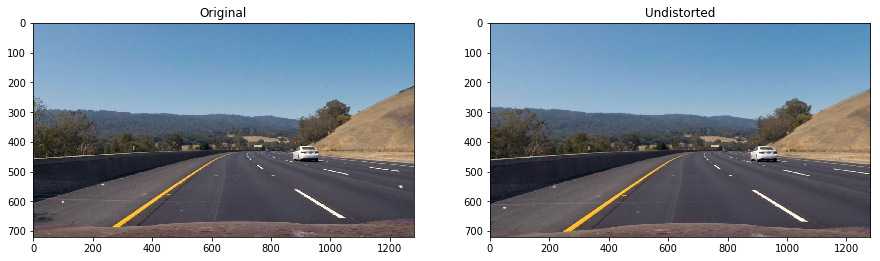

In [112]:
# correct distortion of road image
rimg = mpimg.imread('test_images/test3.jpg')
undist_rimg = cv2.undistort(rimg, cam_mtx, dist_coeff)
arrange_side_by_side(rimg, undist_rimg, 'Original', 'Undistorted')

## Create Thresholded Binary Image

In [85]:
def filter_sobel(img, orientation='x'):
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orientation == 'x':
        sobel = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0)
    elif orientation == 'y':
        sobel = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1)
    else:
        print("Unknown value of orientation.")
        return None
    abs_img = np.absolute(sobel)
    return abs_img * 255 / np.max(abs_img)

def filter_sobel_gradient_magnitude(img, ksize=3):
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=ksize)
    sobely = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=ksize)
    grad_mag = np.sqrt(sobelx**2 + sobely**2)
    return grad_mag * 255 / np.max(grad_mag)

def filter_gradient_direction(img, ksize=3):
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    abs_sobelx = np.absolute(cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=ksize))
    abs_sobely = np.absolute(cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=ksize))
    return np.arctan2(abs_sobely, abs_sobelx)
    
def filter_hls(rgb_img, channel='s'):
    if channel == 'h':
        c = 0
    elif channel == 'l':
        c = 1
    elif channel == 's':
        c = 2
    else:
        print("Undefined parameter channel")
    hls = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HLS)
    return hls[:,:,c]

def create_binary_image(img, thresh_min=50, thresh_max=100):
    binary = np.zeros_like(img)
    binary[(img > thresh_min) & (img < thresh_max)] = 1
    return binary

In [86]:
# apply the Sobel filter for y direction
#sobelx = filter_sobel(rimg, 'x')
#binary_sobelx = create_binary_image(sobelx, 15, 140)
#
#arrange_side_by_side(rimg, binary_sobelx, 'Origin', 'BinaryX')

In [87]:
# apply the Sobel filter for y direction
#sobely = filter_sobel(rimg, 'y')
#binary_sobely = create_binary_image(sobely, 20, 150)
#
#arrange_side_by_side(rimg, binary_sobely, 'Origin', 'Binary')

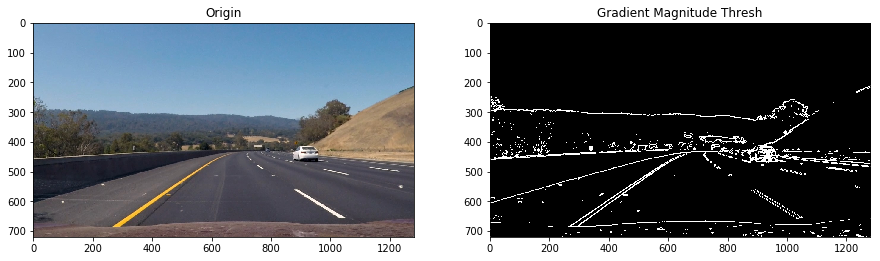

In [113]:
grad_mag = filter_sobel_gradient_magnitude(rimg, ksize=5)
binary_grad_mag = create_binary_image(grad_mag, 30, 170)

arrange_side_by_side(rimg, binary_grad_mag, 'Origin', 'Gradient Magnitude Thresh')

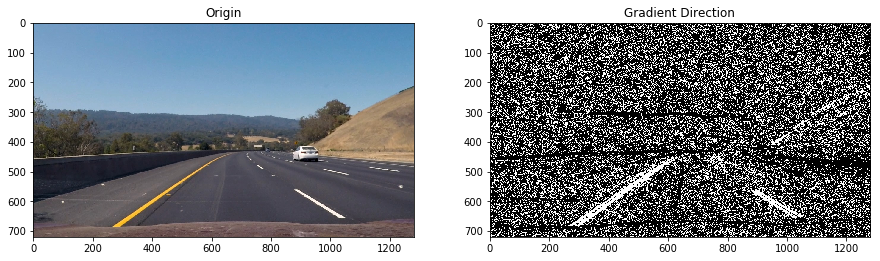

In [114]:
grad_dir = filter_gradient_direction(rimg, ksize=11)
binary_grad_dir = create_binary_image(grad_dir, 0.75, 1.2)

arrange_side_by_side(rimg, binary_grad_dir, 'Origin', 'Gradient Direction')

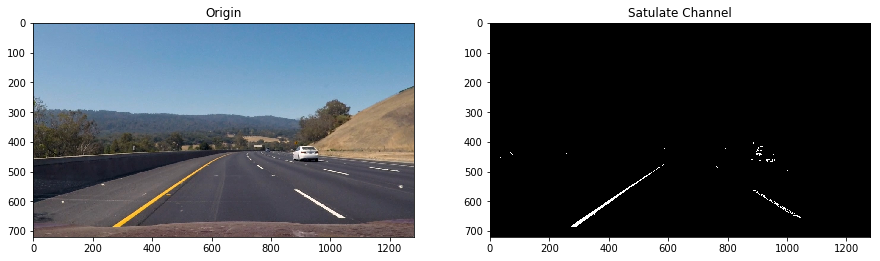

In [115]:
s_img = filter_hls(rimg, 's')
binary_satulate = create_binary_image(s_img, 200, 300)
arrange_side_by_side(rimg, binary_satulate, 'Origin', 'Satulate Channel')

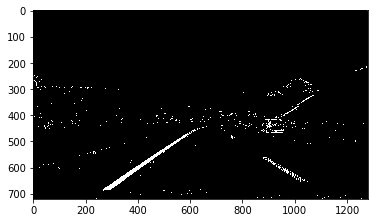

In [116]:
binary = np.zeros_like(binary_grad_dir)
binary[((binary_grad_mag == 1) & (binary_grad_dir == 1) | (binary_satulate == 1))] = 1

plt.imshow(binary, cmap='gray')

## Apply Perspective Transform

In [117]:
#%matplotlib qt
%matplotlib inline

src = np.float32(
    [[840, 546],
     [1051, 677],
     [244, 686],
     [453, 546]])
dst = np.float32(
    [[1051, 463],
     [1051, 686],
     [245, 686],
     [245, 463]])

M = cv2.getPerspectiveTransform(src, dst)

In [124]:
warped = cv2.warpPerspective(binary, M, (rimg.shape[1], rimg.shape[0]), flags=cv2.INTER_LINEAR)
worped_images.append(warped)

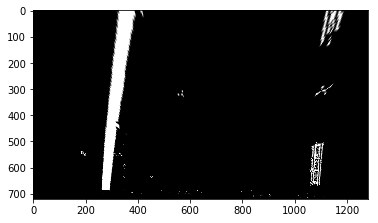

In [126]:
plt.imshow(worped_images[0], cmap='gray')